# Assignment 5

## Problem 1

### Exploring the Data

Load the 'x1_vals' data set and perform an exploratory data analysis
- Create at least two different types of visualizations to help you evaluate possible values for K
- Implement two different analytical methods to narrow your choice of K prior to modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = np.load('x1_vals.npy')
df = pd.DataFrame(data, columns=['x','y'])
df.describe()

,x,y
count,750.000000,750.000000
mean,3.657115,4.405555
std,3.410647,2.738141
min,-2.497642,-1.506952
25%,0.605361,1.632803
50%,3.138275,5.056626
75%,7.306130,6.673648
max,10.112838,10.696392


The data set has two features, which have been labeled 'x' and 'y'.  Each feature contains data in a similar range, with the minimums close to -2 and the max close to 10, but their means and medians are different.

<Axes: xlabel='x', ylabel='y'>

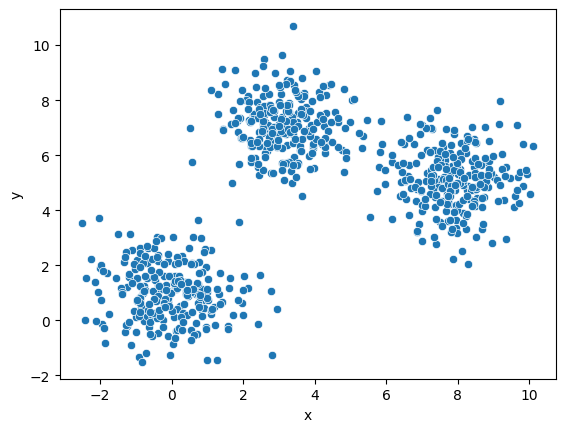

In [2]:
sns.scatterplot(x=df.x, y=df.y)

Visually, there appears to be 3 distinct clusters in the data set that are well separated from each other.

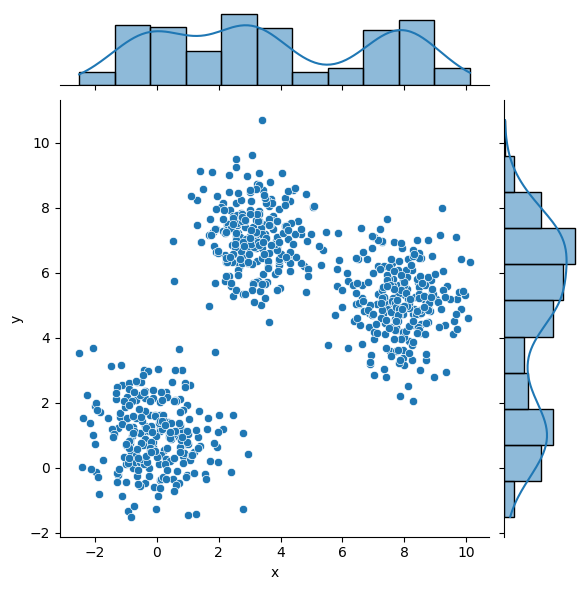

In [3]:
grid = sns.JointGrid(data=df, x='x', y='y')
grid.plot_joint(sns.scatterplot)
grid.plot_marginals(sns.histplot, kde=True)

The x-axis marginal distribution shows 3 distinct clusters.  The y-axis distribution shows a small cluster around $y=1$ and a large cluster around $y=6$.

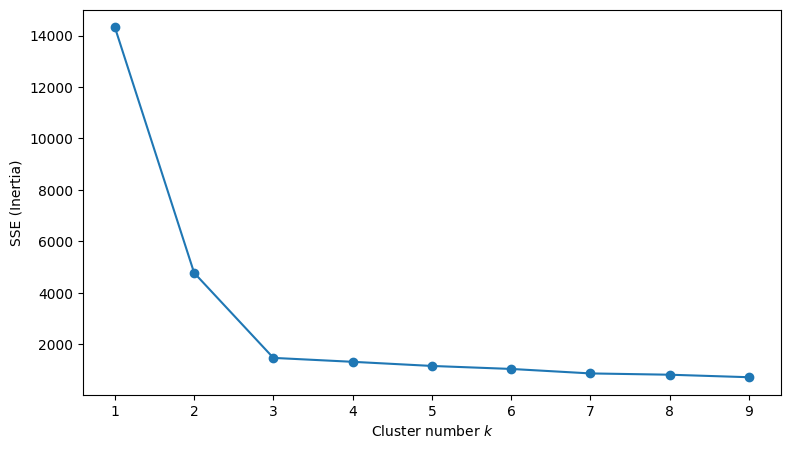

In [4]:
from sklearn.cluster import KMeans

clusters = np.arange(1, 10, 1)
errors = []
for k in clusters:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=4321)
    kmeans.fit(df)
    errors.append(kmeans.inertia_)
    
plt.figure(figsize= (9, 5))
plt.plot(clusters, errors, marker='o')
plt.xlabel('Cluster number $k$')
plt.ylabel('SSE (Inertia)')
plt.show()

When plotting the number of clusters against the kmeans inertia (or sum of squared errors), the biggest elbow in the graph occurs at $k=3$.  This flexion point represents a rapid improvement in SSE before this improvement slightly levels out, confirming that 3 is the optimal number of clusters.

In [5]:
# Fitting a kmeans model using k=3
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=4321)
labels = kmeans.fit_predict(df.values)

In [6]:
# Adapted from Hands-on Machine Learning with Scikit-Learn
# https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
def plot_data(X, labels):
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], c=labels, s=20)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=120, c='gray',
                alpha=0.8, edgecolors='black')

def plot_decision_boundaries(clusterer, X, labels, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins.iloc[0], maxs.iloc[0], resolution),
                         np.linspace(mins.iloc[1], maxs.iloc[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins.iloc[0], maxs.iloc[0], mins.iloc[1], maxs.iloc[1]),
                alpha=0.3)
    plt.contour(Z, extent=(mins.iloc[0], maxs.iloc[0], mins.iloc[1], maxs.iloc[1]),
                linewidths=1, colors='k')
    plot_data(X, labels)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

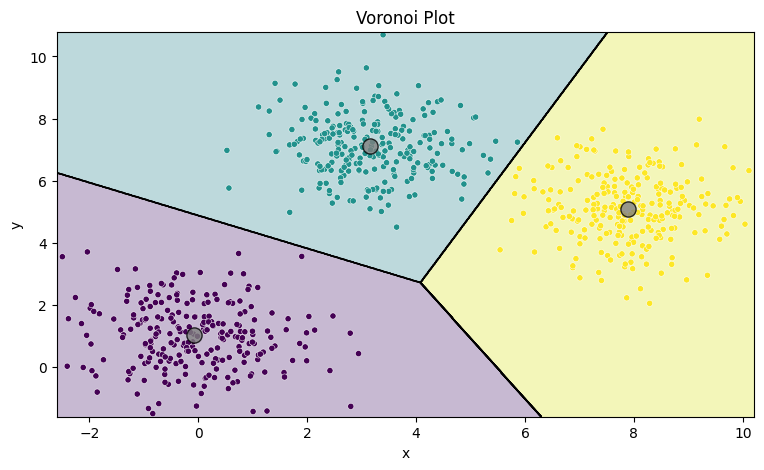

In [7]:
# Create a plot of the results that distinguishes each of the clusters by color
plt.figure(figsize=(9, 5))
plot_decision_boundaries(kmeans, df, labels)
plt.title("Voronoi Plot")
plt.show()

In [8]:
# Extract values for cluster centroids, the number of iterations to convergence, and a measure of cluster ‘coherence’
from sklearn.metrics import silhouette_score

centroids = kmeans.cluster_centers_
num_iters = kmeans.n_iter_
# Could also use Davies-Bouldin score, or Inertia, but these are better as comparison metrics
coherence = silhouette_score(df, kmeans.labels_)

print(f"""
Centroid values: 
{centroids}
Number of iterations: {num_iters}
Cluster Coherence: {coherence}
""")


Centroid values: 
[[-0.07678001  1.00976646]
 [ 3.15664275  7.11149514]
 [ 7.89148283  5.09540347]]
Number of iterations: 3
Cluster Coherence: 0.6885290065091371



### Questions: 
__A. What method(s) did you use to identify an appropriate value for K? Why did you select this method? (5 pts)__

The methods used were visually inspecting the data and creating a plot of the KMeans inertia versus the number of clusters.  It's apparent just from plotting the data that there should be 3 clusters.  This is clearly confirmed in the inertia plot where the largest flexion point is at `k=3`.

__B. What value did you select for K? Does your EDA support this choice? (2 pts)__

I selected a value of 3 for `k`, which is strongly supported by the above analyses.

__C. How many iterations were required before your model converged? (2 pts)__

3 iterations

__D. What were the values for each of your cluster centroids? (2 pts)__

1: -0.076, 1.009  
2:  3.156, 7.111  
3:  7.891, 5.095  

__E. What kmeans measure serves as a proxy for cluster coherence? What value did your model return? Discuss your interpretation of this value. (5 pts)__

I chose the silhouette score as a measure for cluster coherence, which is the mean of the silhouette coefficient for every instance in the data set.  The fitted model returned a value of 0.69 for the silhoutte score.  This value approaches 1 the closer every cluster's intances are to each other and the farther away the instance is to other cluster's data points, so a score of 0.69 is good and indicates the 3 clusters for this model have a strong coherency.

### Creating Silhouette Plots

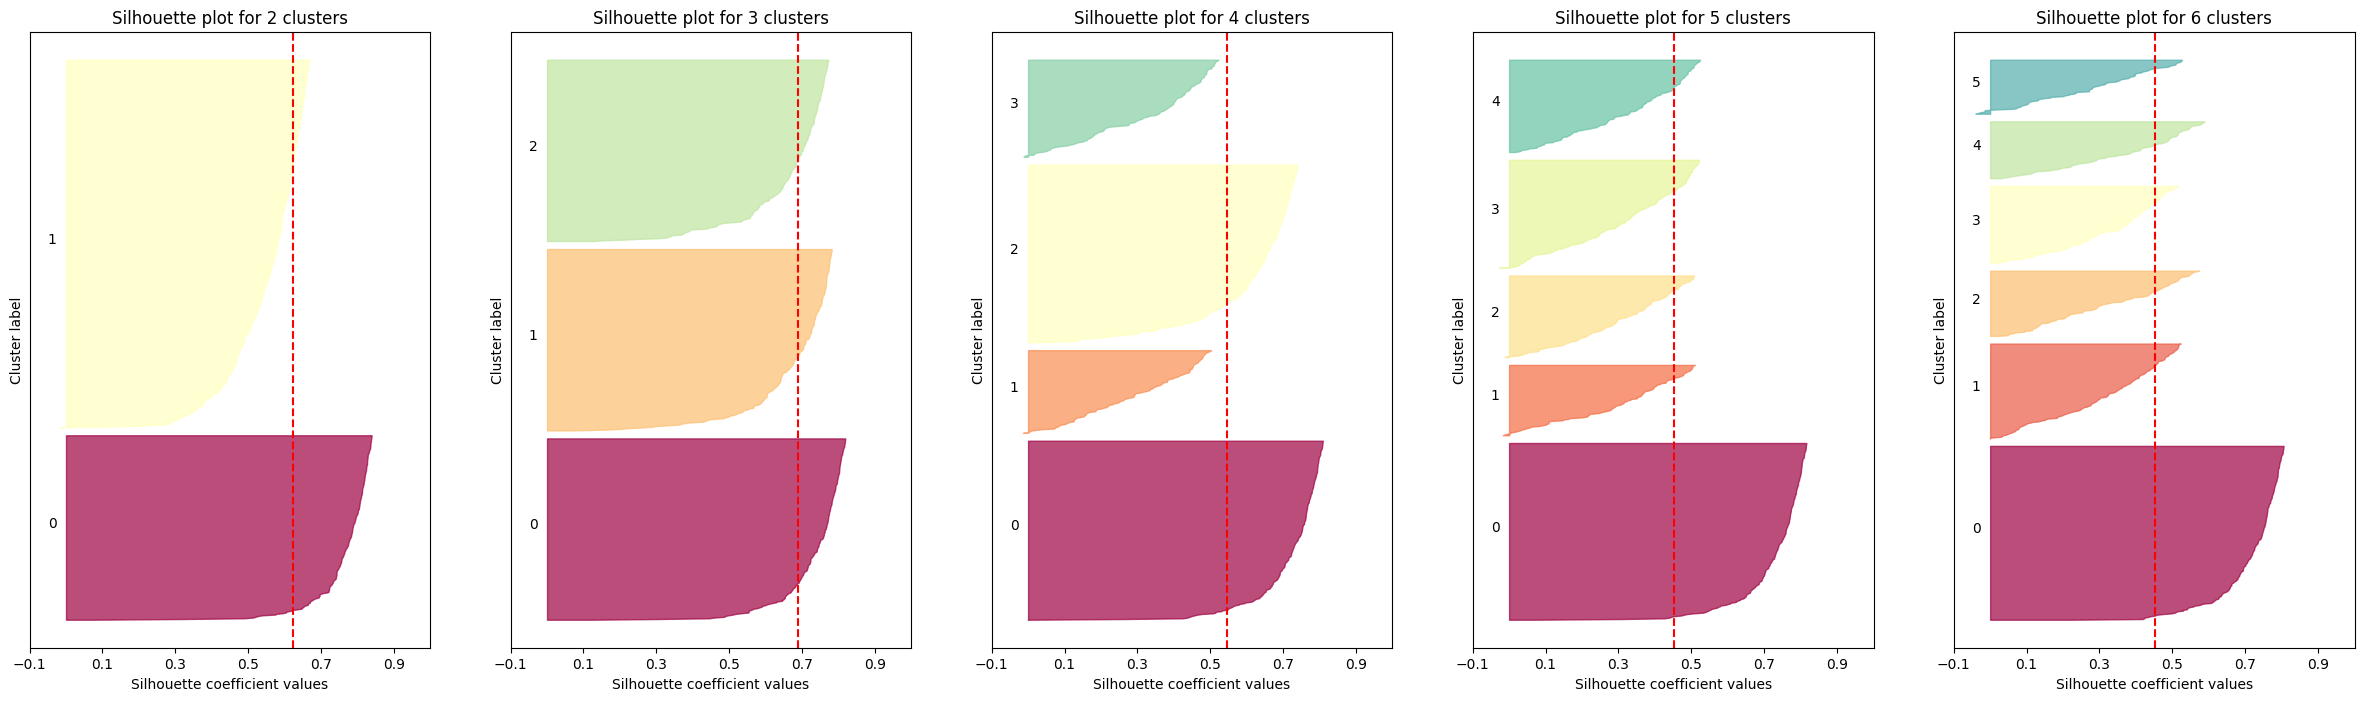

In [9]:
from sklearn.metrics import silhouette_samples

# Range of values for k
range_n_clusters = [2, 3, 4, 5, 6]
plt.figure(figsize=(len(range_n_clusters) * 6, 8))

for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=4321)
    cluster_labels = clusterer.fit_predict(df)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(df, cluster_labels)
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    plt.subplot(1, len(range_n_clusters), i + 1)
    y_lower = 10
    
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        color = plt.colormaps["Spectral"](float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

### Questions:
__A. What information does a silhouette analysis provide? (5 pts)__

A silhuoette plot shows the silhouette score for each instance in a data set.  These scores are grouped by cluster and sorted in ascending order.  This score essentially evaluates how close an instance is to each of the other instances within it's cluster compared to how close the nearest cluster's data points are.  A silouette score can have a maximum value of 1 and a minumum value of -1.  A score close to 1 means the data point is tightly grouped with the other data points in its cluster and is far away from the data points of the next closest cluster.  The red line in the graph shows the average of every silhouette coefficent.

__B. Describe how to interpret the individual silhouette plots in terms of cluster cohesion and separation. What are the key features of the graphs that aid your evaluation? (5 pts)__

The clusters are more coherent the wider each cluster's knife shape in the in plots are and the more of the shape that is right of the red dotted line that represents the total average score for the entire data set.  When more of the cluster is left of the line, the cluster has too many instances that are closer to other clusters.

__C. From the silhouette plots you created, what value of K affords the best cluster assignments? (3 pts)__

The best number of clusters is 3.  The knife shapes in the 3 cluster plots are about equal in size (representing equal sized cluisters) and each shape has a good portion of data points hiher than the average silhouette score.  

## Part 2: External Validation

<Axes: >

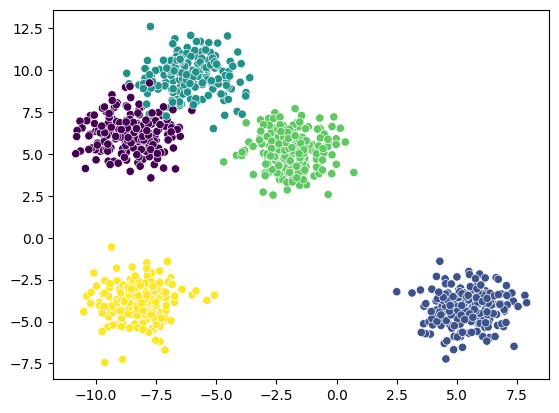

In [10]:
# Use sklearn’s ‘make_blobs’ to create a synthetic dataset for clustering. 
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, n_features=2, centers=5, random_state=4321)
sns.scatterplot(x=X[:,0], y=X[:,1], c=y)

In [11]:
# This gets the actual centers of the clusters to feed into the K-Means model so that the predicted labels match the actual labels
# I'm doing this sctrictly so the colors in the side-by-side scatter plots match, obviously building a model with known parameters 
# defeats the purpose of building a model in the first place, but the end result will still have prediction errors based on the 
# limitations of the K-Means method
df = pd.DataFrame(X, columns=['x1','x2'])
df['y'] = y
centers = df.groupby(y).mean()[['x1','x2']]

In [12]:
# Fit the model and save cluster label predictions
kmeans = KMeans(n_clusters=5, n_init='auto', init=centers)
y_pred = kmeans.fit_predict(X)

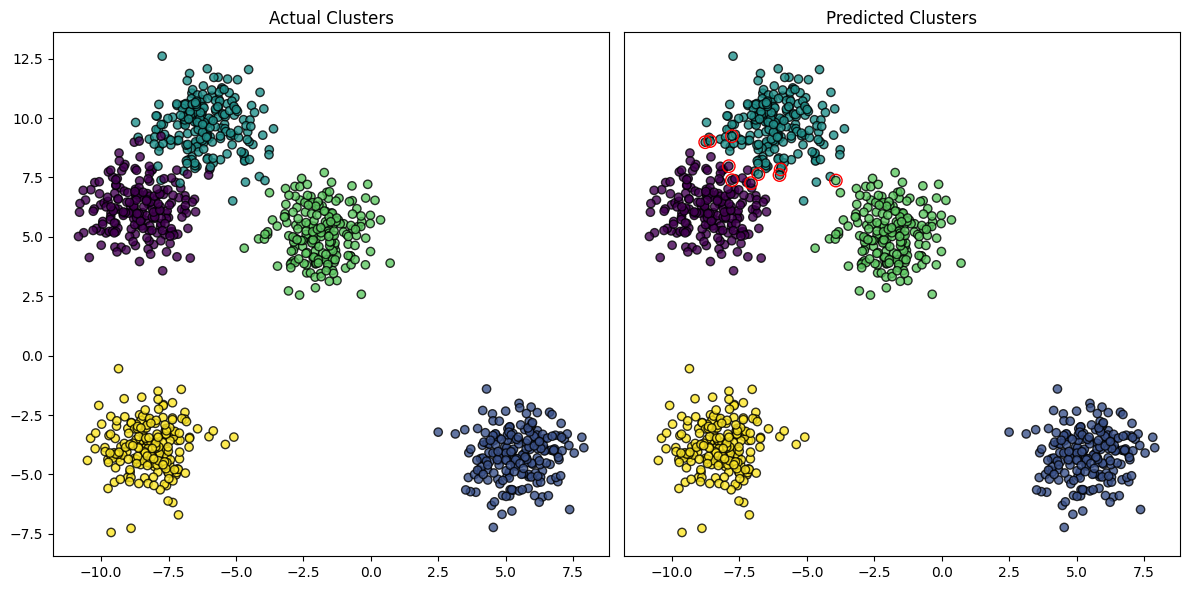

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(x=X[:,0], y=X[:,1], c=y, alpha=0.8, edgecolors='k')
plt.title("Actual Clusters")
plt.subplot(1, 2, 2)
plt.scatter(x=X[:,0], y=X[:,1], c=y_pred, alpha=0.8, edgecolors='k')
plt.scatter(data=df[y != y_pred], x='x1', y='x2', marker='o', facecolors='none', s=80, edgecolor='r')
plt.title("Predicted Clusters")
plt.yticks([])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import rand_score

rand_score(y, y_pred)

0.9921741741741742

### Questions

__A. What method did you select to assess cluster agreement and why? (5 pts)__

Since we know the true label of the clusters, I used a Rand Index to assess how well the clusters were assigned.  The Rand Index is a measure of the number of sample pairs whose cluster assignments are the same for the actual and predicted clusters, or are different in both.  It is easy to interpret - a score of 1 means the predicted clusters are perfectly assigned while a score of 0 means no clusters were assigned correctly.

__B. What do your results of this assessment suggest? (5 pts)__

The Rand index for the trained model is 0.99, meaning the model performed extremely well and correctly assigned most instances to thier true cluster.  This is apparent in the side-by-side scatter plots of the cluster assignments: the five clusters are distinct and most of the predicted assignments match the actual clusters.  The points circled in red are the only discrepencies, the model misclassifed 10 out of 1000 instances. 

## Part 3: Interpreting SSE

__Total SSE is the sum of the SSE for each separate attribute in the Kmeans algorithm. What does it mean if the SSE for one variable is low for all clusters? Low for just one cluster? High for all clusters? High for just one cluster? How could you use the per variable SSE information to improve your clustering? (5 pts)__

If the SSE for one variable is low for all clusters, that means it's between each of the clusters and is relatively equidistant to each of them.  If the SEE is low for just one cluster, this implies the varibale is close to that cluster's centroid and farther from the rest.  A high SEE for all clusters means the varible is not close to any of the cluster's centroids.  If the SEE is high for just one cluster, it means the variable is farther from that cluster than it is to any of the others.

### Local and Global Objective Funtions

For each of the data sets below, an estimation of the resulting clustering is provided:

![inner_outer](./inner_outer_circle.png)
![inner_outer](./circle.png)
![inner_outer](./rectangles.png)

### Density Clustering

Given that MinPts = 3 and EPS = 1, answer the following questions about the below graph.  

__a) Label all point as ‘core points’, ‘boundary points’, and ‘noise’. (5 pts)__  

Core Points: B, C, E, F, J, L, I, M  
Boundary Points: D, G  
Noise: A, H  

__b) What is the clustering result (i.e., how will the data cluster)? (5 pts)__  

Cluster 1: B, C, D, E, F, G  
Cluster 2: J, L, I, M  

![inner_outer](./dbscan.png)

### Entropy vs. SSE  

__Assume you are given a data set of objects, each of which is assigned to one of two classes, and suppose that C1 and C2 are two clusterings produced from this data set. If entropy judges C1 to be a more accurate clustering than C2, is it necessary that SSE will also judge C1 to be a more accurate clustering than C2? (5 pts)__  

Entropy and SSE rely on completely different metrics to evaluate clusterings, so an accurate entropy does not necessitate that the SEE will also indicate a good cohesion.  Entropy only relies on how well data points were clustered compared to thier actual labels (therefore entropy relies on knowing the true membership of each cluster), so the cluster could be completely spread out and have a non-globular shape but could still have a perfect Entropy as long as each data point is properly assigned to the clsuter it's meant to be assigned (again, this requires knowing this information). SSE is a relative measure of the cohesion of the cluster, i.e. the SEE is better the closer each of the cluster's instances are to its centroid and does not care about the true labels of the cluster.

### Part 4: Selecting Clustering Algorithms

In [15]:
data = np.load('x4_vals.npy')
df = pd.DataFrame(data, columns=['x','y'])
df.describe()

,x,y
count,500.000000,500.000000
mean,2.319361,4.906028
std,3.520610,1.495069
min,-3.564887,0.166537
25%,-0.421139,3.797372
50%,1.086455,5.381471
75%,5.288798,5.957691
max,10.717959,8.670240


<Axes: xlabel='x', ylabel='y'>

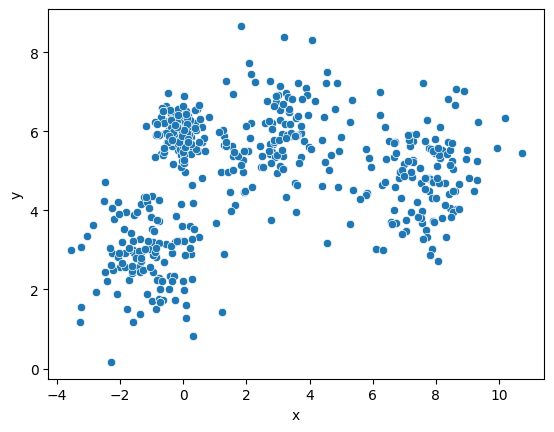

In [16]:
sns.scatterplot(x=df.x, y=df.y)

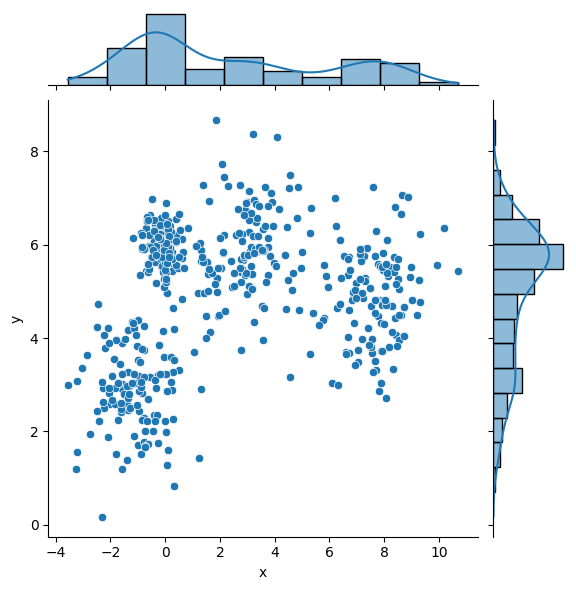

In [17]:
grid = sns.JointGrid(data=df, x='x', y='y')
grid.plot_joint(sns.scatterplot)
grid.plot_marginals(sns.histplot, kde=True)

The above scatter plots show there are likely 4 clusters: one dense cluster around (0,6), and three clusters with high variability below and to the right of the dense cluster.  The marginal density plots shows the x values bunch up around 0 and the y values bunch up around 6.

#### Implement Clustering Algorithms

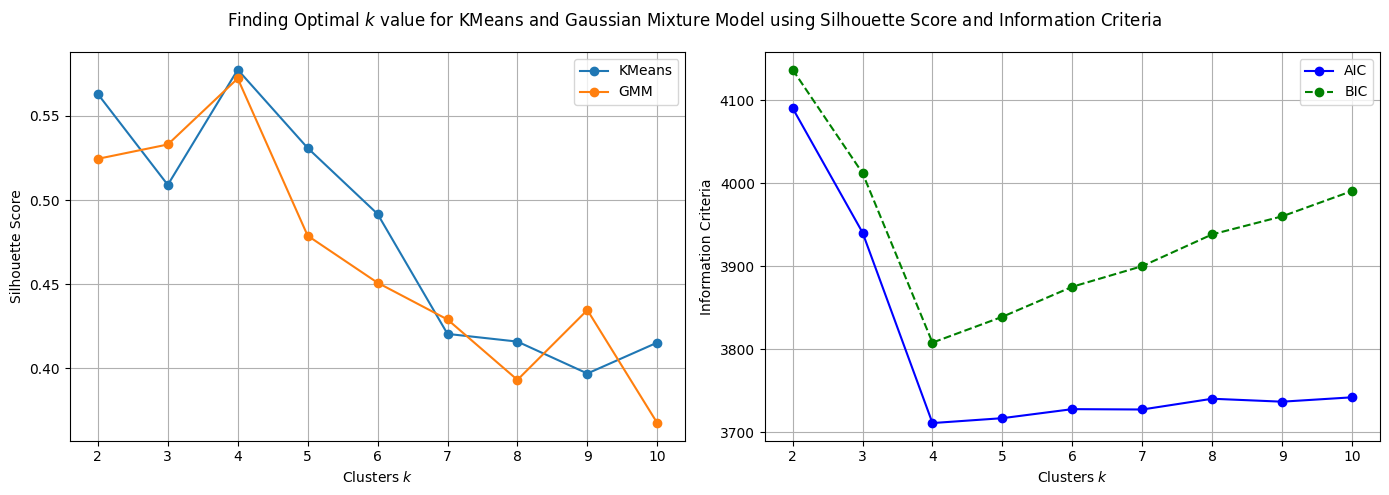

In [18]:
from sklearn.mixture import GaussianMixture
from collections import defaultdict

# Exploring best possible value for k for KMeans and Gaussian Mixture Model
n_clusters = np.arange(2, 11, 1, dtype=int)
silhouettes = defaultdict(list)
aic, bic = [], []

for n in n_clusters:
    # Train the models
    kmeans = KMeans(n_clusters=n, n_init='auto', random_state=4321)
    kmeans_labels = kmeans.fit_predict(df)
    gmm = GaussianMixture(n_components=n, n_init=10, random_state=4321)
    gmm_labels = gmm.fit_predict(df)

    # Record model scores
    silhouettes['KMeans'].append(silhouette_score(df, kmeans_labels))
    silhouettes['GMM'].append(silhouette_score(df, gmm_labels))
    aic.append(gmm.aic(df)), bic.append(gmm.bic(df))

sil_scores = pd.DataFrame.from_dict(silhouettes)
sil_scores.set_index(n_clusters, inplace=True)

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Finding Optimal $k$ value for KMeans and Gaussian Mixture Model using Silhouette Score and Information Criteria")

# Silhouette Scores
ax1 = plt.subplot(1, 2, 1)
sil_scores.plot(ax=ax1, marker='o')
plt.legend()
plt.xlabel("Clusters $k$")
plt.ylabel("Silhouette Score")
plt.grid()

# AIC and BIC
plt.subplot(1, 2, 2)
plt.plot(n_clusters, aic, 'bo-', label='AIC')
plt.plot(n_clusters, bic, 'go--', label='BIC')
plt.xlabel("Clusters $k$")
plt.ylabel("Information Criteria")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

The silhouette score for both KMeans and Gaussian Mixture model indicate that 4 would be the best number of clusters.  The AIC and BIC scores for Gaussian Mixture Models are also minimized at 4 clusters, so 4 clusters is the best choise for these algorithms.

In [19]:
from matplotlib.colors import LogNorm

# Function for plotting GMM models, adapted from Hands-on Machine Learning with Scikit-Learn
# https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
def plot_gaussian_mixture(clusterer, X, labels, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins.iloc[0], maxs.iloc[0], resolution),
                         np.linspace(mins.iloc[1], maxs.iloc[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12), cmap='Blues_r', alpha=0.7)
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k', alpha=0.6)

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=1, colors='k', linestyles='--', alpha=0.9)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], c=labels, edgecolor='k', s=20)

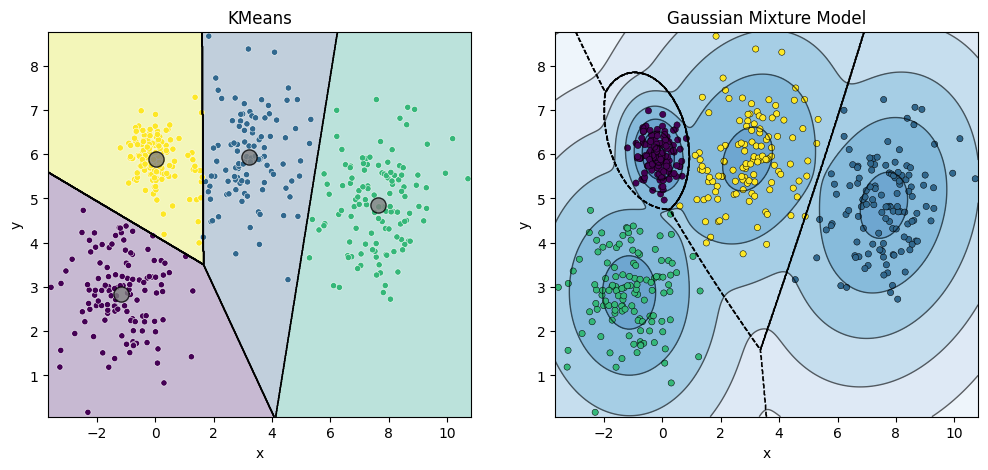

In [20]:
# Retrain the models
kmeans_best = KMeans(n_clusters=4, n_init='auto', random_state=4321)
gmm_best = GaussianMixture(n_components=4, n_init=10, random_state=4321)
kmeans_best_labels = kmeans_best.fit_predict(df.values)
gmm_best_labels = gmm_best.fit_predict(df.values)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundaries(kmeans_best, df, kmeans_best_labels)
plt.title("KMeans")
plt.subplot(1, 2, 2)
plot_gaussian_mixture(gmm_best, df, gmm_best_labels)
plt.title("Gaussian Mixture Model")
plt.show()

The above chart visually demonstrates the clustering using KMeans and Gaussian Mixture Model.  

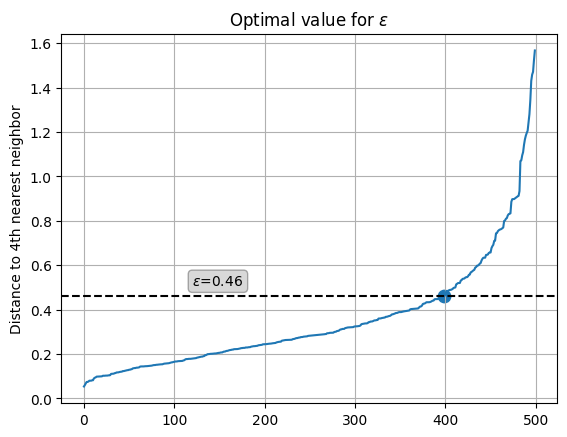

In [21]:
from sklearn.neighbors import NearestNeighbors

# Neighbors/min_samples suggested to be 2 * dimensions by Sanders et. al in Data Mining and Knowledge Discovery
neighbors = 4
nn = NearestNeighbors(n_neighbors=neighbors).fit(df)

# Graph the average distance for 4th nearest neighbor
distances, idx = nn.kneighbors()
k_nearest = np.sort(distances[:,-1])
idxs = np.arange(len(k_nearest))
line = np.linspace(k_nearest[0], k_nearest[-1], len(k_nearest))
max_diff_idx = (line - k_nearest).argmax()  # Assumes max vertical distance approximates max orthogonal distance

plt.plot(k_nearest)
plt.axhline(y=k_nearest[max_diff_idx], color='k', linestyle='--')
plt.scatter(max_diff_idx, k_nearest[max_diff_idx], s=80)
plt.text(120, 0.51, f"$\epsilon$={k_nearest[max_diff_idx]:.2f}", bbox=dict(boxstyle='round', facecolor='gray', alpha=0.3))
plt.grid()
plt.title("Optimal value for $\epsilon$")
plt.ylabel(f"Distance to {neighbors}th nearest neighbor")
plt.show()

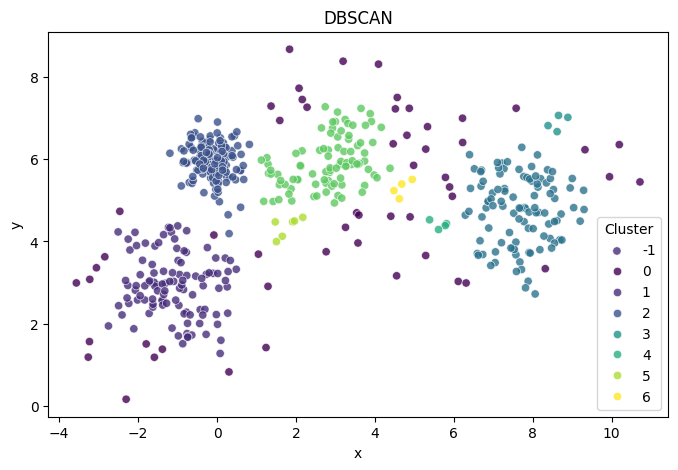

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.46, min_samples=4).fit(df)
db_labels = dbscan.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df.x, y=df.y, hue=db_labels, alpha= 0.8, palette='viridis')
plt.legend(title="Cluster", labels=np.unique(db_labels), loc='lower right')
plt.title("DBSCAN")
plt.show()

The graph above shows the resulting clusters using DBSCAN

In [23]:
from sklearn.cluster import AgglomerativeClustering

linkages = ['ward', 'average', 'complete', 'single']
for n in n_clusters:
    for link in linkages:
        agg_clust = AgglomerativeClustering(n_clusters=n, linkage=link)
        agg_labels = agg_clust.fit_predict(df)
        silhouettes[f'agg_{link}'].append(silhouette_score(df, agg_labels))


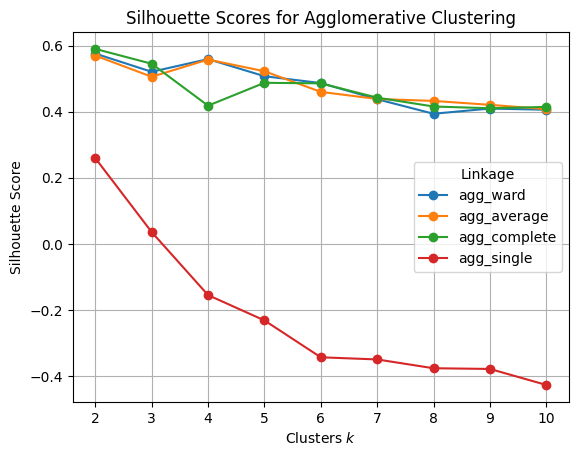

In [24]:
sil_scores = pd.DataFrame.from_dict(silhouettes)
sil_scores.set_index(n_clusters, inplace=True)

sil_scores.drop(columns=['KMeans','GMM']).plot(marker='o')
plt.grid()
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Clusters $k$")
plt.ylabel("Silhouette Score")
plt.legend(title="Linkage")
plt.show()

In [25]:
agg_best_linkage = sil_scores.drop(columns=['KMeans','GMM']).max().idxmax()
agg_best_n = sil_scores.drop(columns=['KMeans','GMM'])[agg_best_linkage].idxmax()

print((
    f"The highest silhouette score was acheived by {agg_best_linkage} with a score of " 
    f"{sil_scores[agg_best_linkage].loc[agg_best_n]:.3f} at {agg_best_n} clusters"
))

The highest silhouette score was acheived by agg_complete with a score of 0.590 at 2 clusters


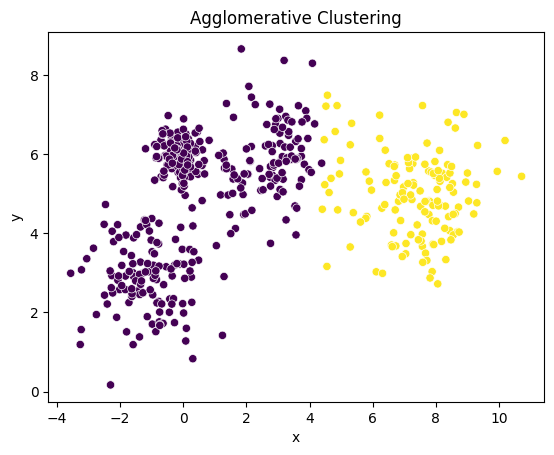

In [26]:
agg_best = AgglomerativeClustering(n_clusters=2, linkage='complete')
agg_best_labels = agg_best.fit_predict(df)

sns.scatterplot(x=df.x, y=df.y, c=agg_best_labels)
plt.title("Agglomerative Clustering")
plt.show()

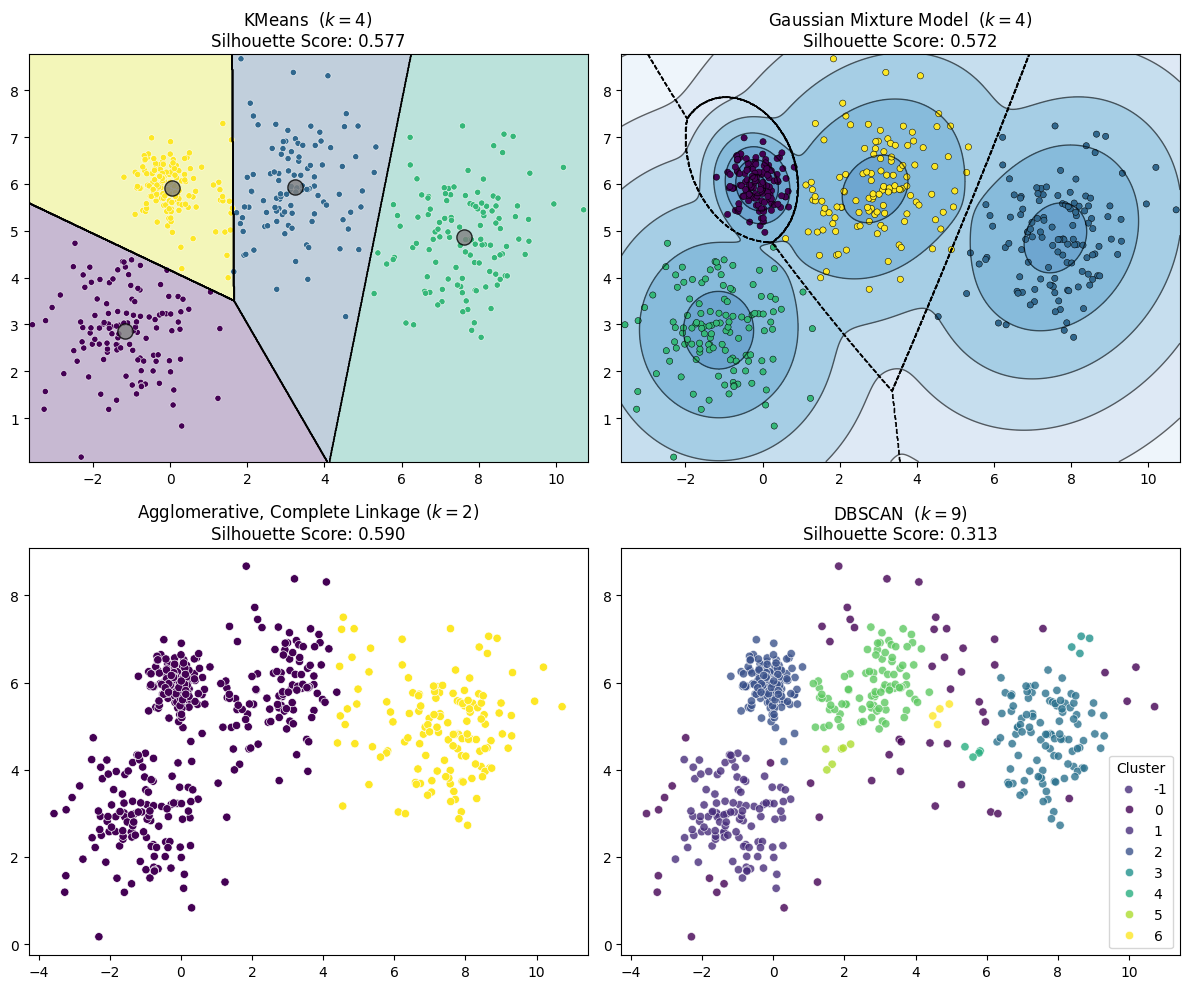

In [27]:
# Comparing all the clusterings side-by-side
plt.figure(figsize=(12, 10))

# KMeans
plt.subplot(2, 2, 1)
plot_decision_boundaries(kmeans_best, df, kmeans_best_labels)
plt.title(f"KMeans\t($k={kmeans_best.n_clusters}$)\nSilhouette Score: {sil_scores['KMeans'].loc[kmeans_best.n_clusters]:.3f}")
plt.xlabel(None)
plt.ylabel(None)

# Gaussian Mixture Model
plt.subplot(2, 2, 2)
plot_gaussian_mixture(gmm_best, df, gmm_best_labels)
plt.title(f"Gaussian Mixture Model\t($k={gmm_best.n_components}$)\nSilhouette Score: {sil_scores['GMM'].loc[gmm_best.n_components]:.3f}")
plt.xlabel(None)
plt.ylabel(None)

# Agglomerative
plt.subplot(2, 2, 3)
sns.scatterplot(x=df.x, y=df.y, c=agg_best_labels)
plt.title(f"Agglomerative, Complete Linkage\t($k={agg_best.n_clusters}$)\nSilhouette Score: {sil_scores[agg_best_linkage].loc[agg_best.n_clusters]:.3f}")
plt.xlabel(None)
plt.ylabel(None)

# DBSCAN
plt.subplot(2, 2, 4)
sns.scatterplot(x=df.x, y=df.y, hue=db_labels, alpha= 0.8, palette='viridis')
plt.legend(title="Cluster", labels=np.unique(db_labels), loc='lower right')
plt.title(f"DBSCAN\t($k={len(np.unique(db_labels))}$)\nSilhouette Score: {silhouette_score(df, db_labels):.3f}")
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()

Quantitatively, Agglomerative Complete Linkage performed the best since it has the highest Silhouette Score of 0.59, so the following questions will be answered with respect to that method.

### Questions:
__A. What method(s) did you use to identify an appropriate value for K? Why did you select this method(s)? (5 pts)__  

An appropriate value for $k$ was found by iterating over both the linkage methods for Agglomerative clustering and through a number of clusters.  The linkage and number of clusters that produced the best silhouette score was chosen for the final cluster model.  The silhouette score is a good measure of how close a clusters data points are to each other relative to how far each data point is to the data points of the next closest cluster, which fits the globular nature of the data.

__B. What value did you select for K? Does your EDA support this choice? (5 pts)__  

For Agglomerative clustering, 2 was chosen as the value for $k$ since it had the best silhouette score.  However, this does not match either with visual inspection or the $k$'s chosen by KMeans and Gaussian Mixture.  This is likely because, visually, one cluster is densely packed while the data points in the other clusters are spread out - making the number of clusters relatively ambiguous since they overlap and lowering the assessment of cluster cohesion.

__C. Why is the algorithm that you selected for your final clustering model the best choice among those you evaluated? (5 pts)__  

Agglomerative is only the best choice quantitatively, but even so the margin by which is scores better than KMeans and GMM is relatively small.  Visually, the best choice appears to be the Gaussian Mixture Model since it captures the high density cluster well while giving a wider boundary to the less tight clusters, but even then KMeans has a higher silhouette score than the GMM model. In practice, having a high scoring KMeans is not the worse outcome since it is computationally cheaper than GMM.  

## Problem 5. Comparing Algorithms  

Compare the relative strengths and weaknesses of the clustering methods listed in Problem 3. Include your observations in a table form. (10 pts)

| Algorithm        | Strength | Weakness |
|------------------|----------|----------|
| KMeans           | Computationally cheap, works fast, simple to understand     | Clusters must be globular, have good separation, <br>and be relatively equal in size to work well |
| Gaussian Mixture | Identifies clusters with different shapes and sizes,<br>as long as the data has a normal distribution | Does not handle non-normal data well<br>Performance is inhibited by outliers |
| DBSCAN           | Works on clusters of any shape/size <br>Is resistant to outliers  | Weak to clusters with different densities |
| Agglomerative    | Combines clustering algorithms to handle <br>different types of clusters | Favors large clusters, computationally expensive |